### Land Cover performance assessment

This notebook is designed to assess performance of Land Cover collection 3 with respective to a dataset that 
contain truth data for each level-3 class.  The analysis additionally measures performance at level-1 and level-2.

The dataset used as the truth is the same dataset used for validation of C2.  
Location of data:
    
- 2010: s3://dea-public-data-dev/lccs_validation/Landcover_validation_points_shapefiles/2010_validation_complete.dbf
- 2015: s3://dea-public-data-dev/lccs_validation/Landcover_validation_points_shapefiles/2015_validation_complete.dbf

We have also added Koppen climate zone and state information to the above data:
    
- 2010: s3://dea-public-data-dev/lccs_validation/Landcover_validation_points_shapefiles/Landcover_validation_points_2010_C3_v3.shp

- 2015:  s3://dea-public-data-dev/lccs_validation/Landcover_validation_points_shapefiles/Landcover_validation_points_2015_C3_v3.shp

A copy of the abpve two files are put under the data folder and used for analysi.

Performance report: 

- https://geoscienceau.sharepoint.com/:p:/r/sites/DEAProjects/_layouts/15/Doc.aspx?sourcedoc=%7BA21F6DD5-AB37-42A6-82BD-2F97875D4B3B%7D&file=c2-vs-c3-precision_assessment_v1.pptx&action=edit&mobileredirect=true

In [1]:
!pip install simpledbf

In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os

from simpledbf import Dbf5

/env/lib/python3.8/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.11.0-CAPI-1.17.0). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_2073/1216578609.py:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import 

In [3]:
L1_classes_definition = {'Non-Vegetated': 'Non-Vegetated', 'Vegetated': 'Vegetated'} 

L2_classes_definition = {'VT': 'Vegetated Terrestrial', 'NAV': 'NAV', 
                         'NVT': 'Non-Vegetated Terrestrial', 'Water': 'Water'} 

L3_classes_definition = {'CTV': 'Cultivated Terrestrial Vegetation',
                         'NTV': '(Semi-) Natural Terrestrial Vegetation',
                         'NAV': 'Natural Aquatic Vegetation',            
                         'AS': 'Artificial Surface',
                         'NS': 'Natural Bare Surface',
                         'Water': 'Water'
                        }


In [4]:
files = [f"data/Landcover_validation_points_2010_C3_v3.dbf", f"data/Landcover_validation_points_2015_C3_v3.dbf"]
years = [2010, 2015]

df = pd.DataFrame()

for file, year in zip(files, years):    
    dbf = Dbf5(file).to_dataframe()    
    dbf['year'] = year
    df = pd.concat([df, dbf])
df.columns

Index(['class_c2', 'output', 'processed', 'cluster', 'fid', 'class_c3',
       'state', 'BOMkoppen', 'year'],
      dtype='object')

In [5]:
# define the group by class - currently either year, BOMkoppen or state

group_by_class = 'BOMkoppen' 

# Set analysis_level level-x, options are Level-1, Level-2 and Level-3
analysis_level ='Level-3'

# Only process 2015 data
# df = df[df['year'] == 2015]
# df['year'].unique()

In [6]:
# df.groupby('BOMkoppen')['output'].value_counts()

In [7]:
# Check the classes 

df['class_c2'].unique(), df['class_c3'].unique(), len(df[df['class_c3'] == '0'])

(array(['111', '112', '216', '124', '215', '220'], dtype=object),
 array(['112', '111', '216', '124', '215', '220', '0'], dtype=object),
 1)

In [8]:
# Remove Nodata from level3 - currently there is a single data point with no data value in C3
# This can be safely deleted without impacting statistics 

df = df[df['class_c3'] != '0']

In [9]:
# Check the classes again

np.sort(df['class_c2'].unique()), np.sort(df['class_c3'].unique()), np.sort(df['output'].unique())

(array(['111', '112', '124', '215', '216', '220'], dtype=object),
 array(['111', '112', '124', '215', '216', '220'], dtype=object),
 array(['111', '112', '124', '215', '216', '220'], dtype=object))

In [10]:
# apply String mapping to level3 classes and Koppen classes 

l3_classes = {'111':'CTV', '112':'NTV', '124':'NAV', '215':'AS', '216':'NS', '220':'Water'}

koppen_classes = {0 :'Nodata', 6 :'Equatorial', 5 : 'tropical', 4 : 'subtropical',
                  3 : 'desert', 2 : 'grassland', 1 : 'temperate'
                 }

for collection in ['c2', 'c3']:    
    df[f'class_{collection}'] = df[f'class_{collection}'].map(l3_classes)
    
df['output'] = df['output'].map(l3_classes)
df['BOMkoppen'] = df['BOMkoppen'].map(koppen_classes)

In [11]:
# Group Level 3 classes to form level 1
if analysis_level == 'Level-1':    
    for collection in ['c2', 'c3']:
        df[f'class_{collection}'] = df[f'class_{collection}'].replace(['CTV', 'NTV', 'NAV'], 'Vegetated').replace(['AS', 'NS', 'Water'], 'Non-Vegetated')
        
    df[f'output'] = df[f'output'].replace(['CTV', 'NTV', 'NAV'], 'Vegetated').replace(['AS', 'NS', 'Water'], 'Non-Vegetated')
        
elif analysis_level == 'Level-2':
    for collection in ['c2', 'c3']:
        df[f'class_{collection}'] = df[f'class_{collection}'].replace(['CTV', 'NTV'], 'VT').replace(['AS', 'NS'], 'NVT')
    df[f'output'] = df[f'output'].replace(['CTV', 'NTV'], 'VT').replace(['AS', 'NS'], 'NVT')
    


Text(0.5, 1.0, 'C3 Level-3')

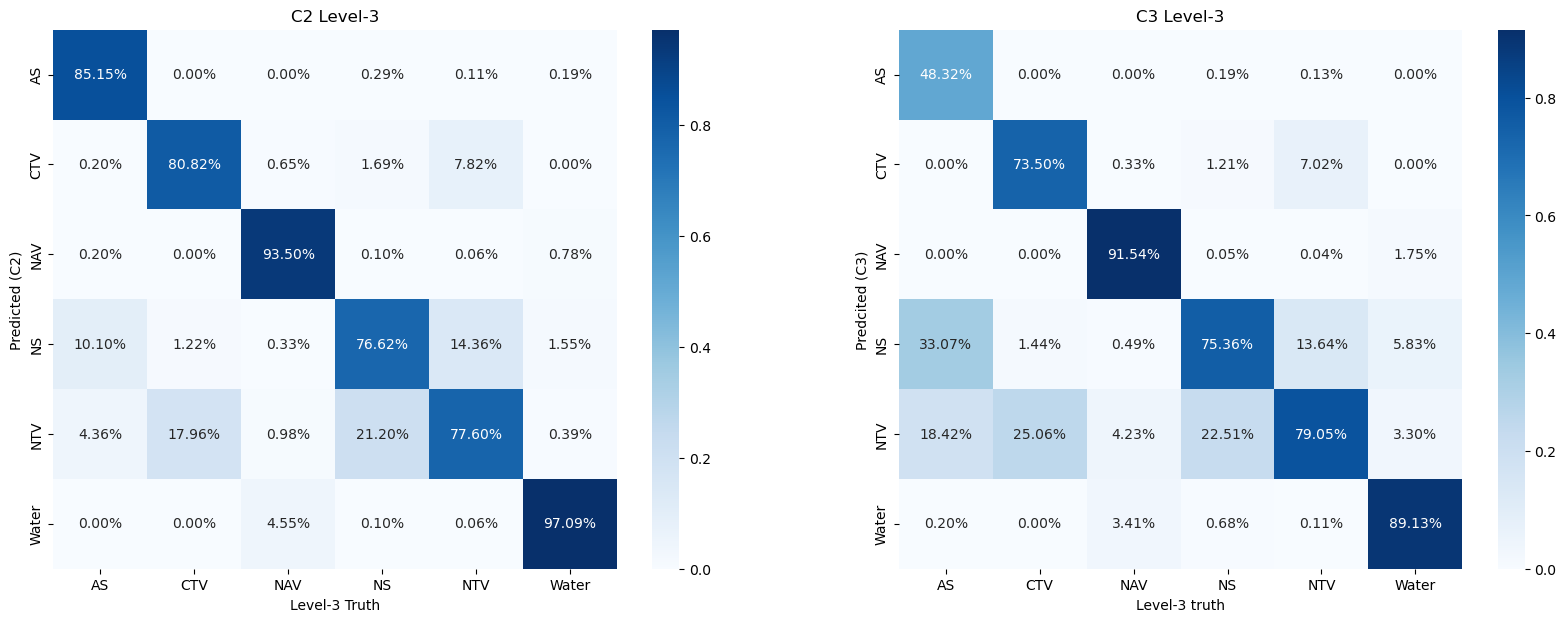

In [12]:
# PLot Confusion Matrix

fig, axes = plt.subplots(ncols=2, figsize=(20, 7))
ax1, ax2 = axes
df_c2 = pd.crosstab(df['class_c2'] , df['output'], rownames=['Predicted (C2)'], colnames=[f'{analysis_level} Truth'], normalize='columns')
sns.heatmap(df_c2, annot=True,  ax=ax1, fmt='.2%', cmap='Blues')
ax1.set_title(f'C2 {analysis_level}')

df_c3 = pd.crosstab(df['class_c3'], df['output'], rownames=['Predcited (C3)'], colnames=[f'{analysis_level} truth'], normalize='columns')
sns.heatmap(df_c3, annot=True,  ax=ax2, fmt='.2%', cmap='Blues')
ax2.set_title(f'C3 {analysis_level}')

In [13]:
# Create a directory for intermediate results
path = './tmp'
if not os.path.exists(path):
    os.makedirs(path)

In [14]:
from sklearn.metrics import accuracy_score

for collection in ['c2', 'c3']:    
    # Compute per-year accuracy for a collection
    report = df.groupby([group_by_class]).apply(lambda x: accuracy_score(x['output'], x[f'class_{collection}'])).to_frame(name='Overall_accuracy')          
    report['Support'] = df.groupby([group_by_class]).apply(lambda x: len(x))
    
    # Computer overall accuracy a collection
    overall = pd.DataFrame({'Overall_accuracy': accuracy_score(df['output'], df[f'class_{collection}']), 'Support': len(df)}, index=['Overall'])
    report = pd.concat([report, overall], axis=0).round(2)         
    
    # Write the results to disk
    report.to_csv(f'{path}/overall_accuracy_{collection}.csv')

In [15]:
# Generate the accuracy metrics for each class at the level specified and per collection
# The results are stored it on disk

from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

# Precision = TP/(TP+FP)
# Recall/TP = TP/(TP+FN)
# F1_score = 2 * Percision * Recall/ (Percision + Recall)

if analysis_level == 'Level-3':
    cols = ['CTV', 'NTV', 'NAV', 'AS', 'NS', 'Water']
elif analysis_level == 'Level-2':
    cols = ['VT', 'NAV', 'NVT', 'Water']
elif analysis_level == 'Level-1': 
    cols= ['Vegetated', 'Non-Vegetated']
else:
    raise ValueError(f"Analysis level {analysis_level} is not defined!")
    
def format_report(accuracy_df, year=None):            
    report = pd.DataFrame(accuracy_df).transpose()        
    report = report.reindex(cols, axis=0).T.round(2)
    return report 

for collection in ['c2', 'c3']:  
    # Measure overall accuracy
    report = format_report(classification_report(df['output'], df[f'class_{collection}'], output_dict=True))  
    report[group_by_class] = 'all'

    # Measure accuracy per class of variable of interest e.g. climate or state
    for key, y_df in df.groupby(group_by_class):
        report_y = format_report(classification_report(y_df['output'], y_df[f'class_{collection}'], output_dict=True), year)
        report_y[group_by_class] = key
        report = pd.concat([report, report_y], axis=0)

    report.set_index([group_by_class], append=True, inplace=True)
    report.to_csv(f'{path}/accuracy_per_class_{collection}.csv')

/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and 

In [16]:
# Load the data from disk for each collection - result of the previous step
c2_df = pd.read_csv(f'{path}/accuracy_per_class_c2.csv', index_col=[0, 1])
c3_df = pd.read_csv(f'{path}/accuracy_per_class_c3.csv', index_col=[0, 1])

In [17]:
# Generate the differece between the CMs for C3 and C2

if analysis_level == 'Level-1':
    level_vars = L1_classes_definition.keys()
elif analysis_level == 'Level-2':
    level_vars = L2_classes_definition.keys()
elif analysis_level == 'Level-3':
    level_vars = L3_classes_definition.keys()
else:
    raise ValueError('Level is not supported')

diff_df = pd.DataFrame()
for col in level_vars:
    diff_df[col] = c3_df[col] - c2_df[col]  

In [18]:
# Delete the support column since the numbers haven't changed between C2 and C3
# the following df stores the counts of groups

c2_df_support = c2_df.drop(index=['precision', 'recall', 'f1-score', 'recall'], level=0) 

c2_df.drop(index=['support', 'f1-score', 'precision'], axis=1, inplace=True, level=0) 
# c2_df.drop(index=['support'], axis=1, inplace=True, level=0) 

c3_df.drop(index=['support', 'f1-score', 'precision'], axis=1, inplace=True, level=0) 
# c3_df.drop(index=['support'], axis=1, inplace=True, level=0) 

Text(0.5, 1.0, 'Count of Data Points per BOMkoppen')

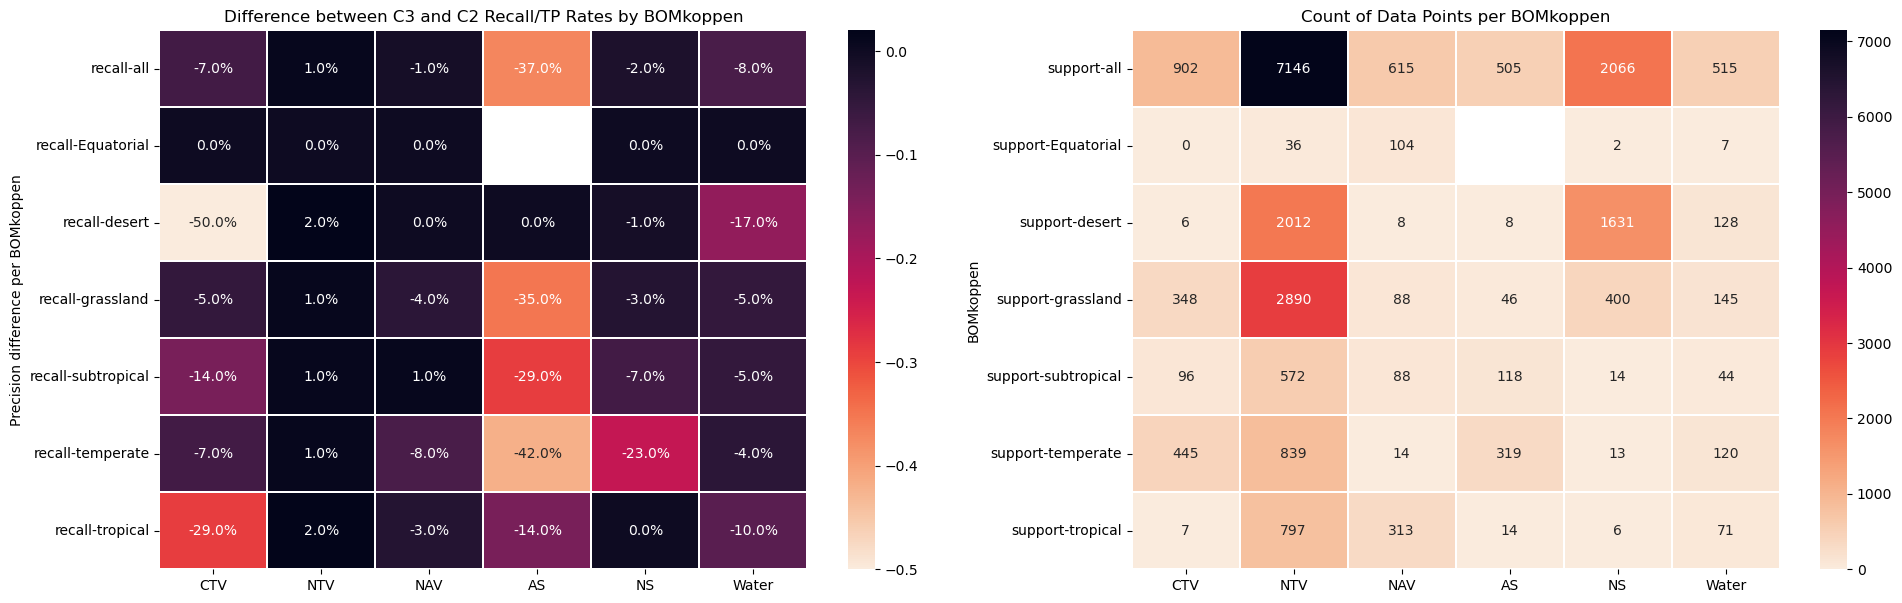

In [19]:
# Plot a heatmap of the difference between the two Collections per class
# The heatmap shows the difference in recall values for each value in the group-by variable


fig, axes = plt.subplots(ncols=2, figsize=(23, 7))
ax1, ax2 = axes

cmap = sns.cm.rocket_r

diff = c3_df - c2_df
sns.heatmap(diff, ax=ax1, linewidths=0.30, annot=True, fmt='.1%', cmap=cmap)
ax1.set(ylabel=f'Precision difference per {group_by_class}')
ax1.set_title(f'Difference between C3 and C2 Recall/TP Rates by {group_by_class}')

sns.heatmap((c2_df_support), ax=ax2, linewidths=0.30, annot=True, fmt='g', cmap=cmap, )
ax2.set(ylabel=f'{group_by_class}')
ax2.set_title(f'Count of Data Points per {group_by_class}')


Text(0.5, 1.0, 'C3')

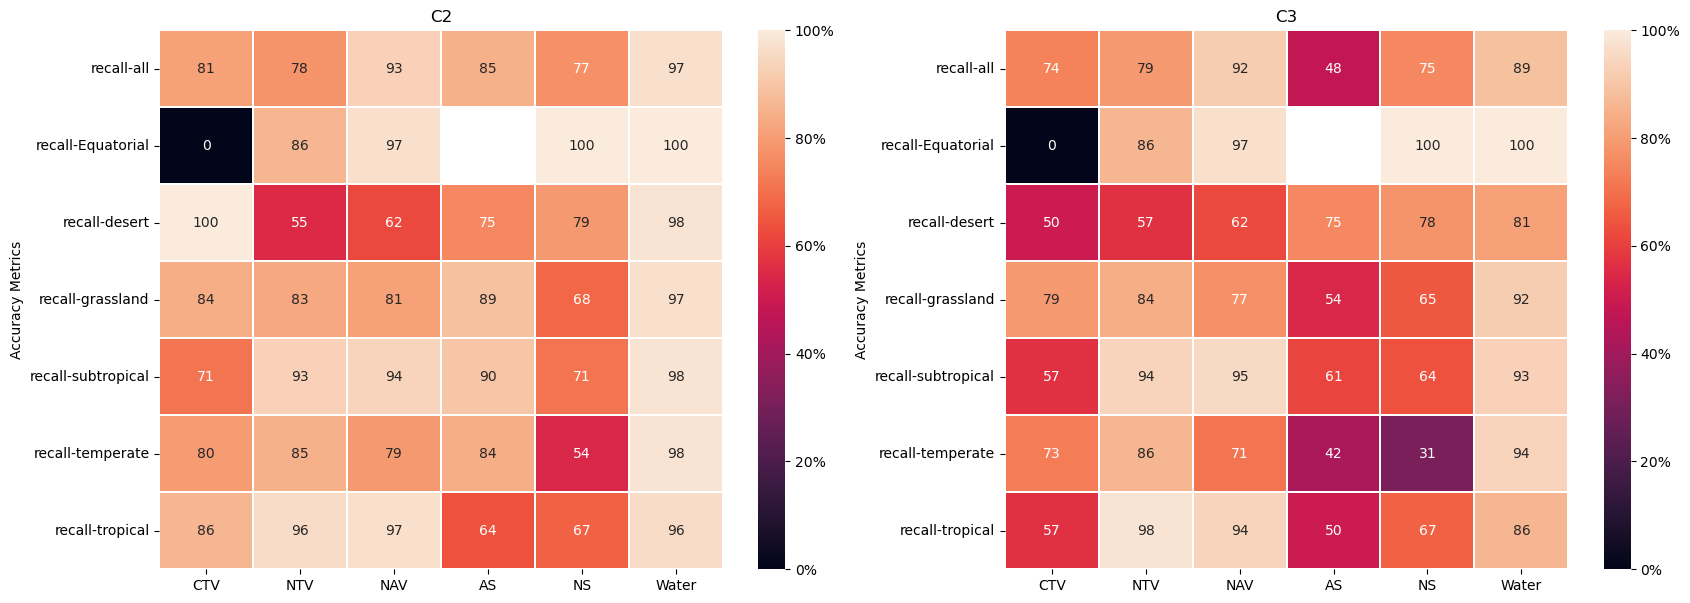

In [20]:
# Plot the recall/TP per groupby variable for each collection


fig, axes = plt.subplots(ncols=2, figsize=(20, 7))
ax1, ax2 = axes

sns.heatmap(c2_df*100, ax=ax1, linewidths=0.30, annot=True, fmt='g', cbar_kws={'format': '%.0f%%'})
ax1.set(ylabel='Accuracy Metrics')
ax1.set_title("C2")
sns.heatmap(c3_df*100, ax=ax2, linewidths=0.30, annot=True, fmt='g', cbar_kws={'format': '%.0f%%'})
ax2.set(ylabel='Accuracy Metrics')
ax2.set_title("C3")